# **Imports**

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

RANDOM_SEED = 6    # Set a random seed for reproducibility!

df_features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")
df_labels = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

# **Building Model**

We'll use OneHotEncoder for the non-binary columns.

In [119]:
numeric_cols = df_features.columns[df_features.dtypes != "object"].values
object_cols = df_features.columns[df_features.dtypes == "object"].values

##### **PreProcessing**

In [104]:
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

categprocal_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('ordinal_encoder', OrdinalEncoder()),
    ('standard_scaler', StandardScaler(with_mean=False))
])

In [105]:
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("encoder", categprocal_preprocessing_steps, object_cols)
    ],
    remainder = "drop"
)

##### **Estimators & Pipeline**

In [106]:
estimators = MultiOutputClassifier(estimator=LogisticRegression(penalty="l2", C=1))

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [107]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df_features,
    df_labels,
    test_size=0.33,
    shuffle=True,
    stratify=df_labels,
    random_state=RANDOM_SEED
)

In [108]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)

print(preds)

[array([[0.64292216, 0.35707784],
       [0.87900568, 0.12099432],
       [0.78191587, 0.21808413],
       ...,
       [0.92954797, 0.07045203],
       [0.9051025 , 0.0948975 ],
       [0.93754855, 0.06245145]]), array([[0.55257991, 0.44742009],
       [0.53674952, 0.46325048],
       [0.24666428, 0.75333572],
       ...,
       [0.85907491, 0.14092509],
       [0.87111047, 0.12888953],
       [0.14271657, 0.85728343]])]
CPU times: user 725 ms, sys: 89.3 ms, total: 814 ms
Wall time: 296 ms


In [109]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (8814, 2)
test_probas[1].shape (8814, 2)


This has given us back a list of two (n_obs, 2) arrays. 

The first array is for `h1n1_vaccine`, and the second array is for `seasonal_vaccine`. 

The two columns for each array are probabilities for class 0 and class 1 respectively. That means we want the second column (index 1) for each of the two arrays. Let's grab those and put them in a data frame.

In [110]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.357078,0.447420
16516,0.120994,0.463250
3106,0.218084,0.753336
16981,0.750555,0.909382
19111,0.245490,0.701567


This competition uses [ROC AUC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) as the metric. Let's plot ROC curves and take a look. Unfortunately, scikit-learn's convenient [`plot_roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) doesn't support multilabel, so we'll need to make the plot ourselves.

In [111]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

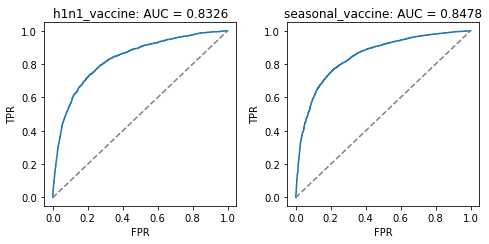

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

**A cool improvement from the benchmark solution!**

In [113]:
roc_auc_score(y_eval, y_preds)

0.8401647135544396

# **Retrain Model on Full Dataset**

Now that we have an idea of our performance, we'll want to retrain our model on the full dataset before generating our predictions on the test set.

In [114]:
%%time 

full_pipeline.fit(df_features, df_labels)

None   # So we don't print out the whole pipeline representation

CPU times: user 775 ms, sys: 82.9 ms, total: 858 ms
Wall time: 349 ms


# **Generating The Predictions For The Test Set**

Let's make predictions on the test set! Again, for this competition, we want the probabilities, not the binary label predictions. We'll again use the `.predict_proba` method to get those.

In [115]:
test_features_df = pd.read_csv("data/test_set_features.csv", index_col="respondent_id")
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

[array([[0.91695575, 0.08304425],
        [0.95834838, 0.04165162],
        [0.56624421, 0.43375579],
        ...,
        [0.85592959, 0.14407041],
        [0.94691892, 0.05308108],
        [0.45103536, 0.54896464]]), array([[0.72898537, 0.27101463],
        [0.95719799, 0.04280201],
        [0.32252371, 0.67747629],
        ...,
        [0.76647665, 0.23352335],
        [0.56637592, 0.43362408],
        [0.42297874, 0.57702126]])]

As before, this gives us back two arrays: one for `h1n1_vaccine`, and one for `seasonal_vaccine`. The two columns for each array are probabilities for class 0 and class 1 respectively. That means we want the second column (index 1) for each of the two arrays.

Let's read in the submission format file so we can put our predictions into it.

We want to replace those 0.5s and 0.7s with our predictions.

First, make sure we have the rows in the same order by comparing the indices. Then, we can drop in the appropriate columns from our predicted probabilities.

In [116]:
submission_df = pd.read_csv("data/submission_format.csv", index_col="respondent_id")
submission_df.head()

# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.083044,0.271015
26708,0.041652,0.042802
26709,0.433756,0.677476
26710,0.480915,0.883912
26711,0.212805,0.487306


In [117]:
submission_df.to_csv('data/solution-2.csv', index=True)

!head data/solution-2.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.0830442524681975,0.27101462718739794
26708,0.04165162381857463,0.04280200965912304
26709,0.43375578713126883,0.6774762948916545
26710,0.48091481231816663,0.8839123113746116
26711,0.21280514614521795,0.48730637910017116
26712,0.43666667431218026,0.922423204645907
26713,0.3779868547572389,0.5151121781247984
26714,0.13618552002406908,0.2713071438910558
26715,0.04289038416738773,0.18772112292879767
